<a href="https://www.kaggle.com/code/lorresprz/cicy4-training-results-inference-all-models?scriptVersionId=181193491" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CICY4: Training results + Inference [All models]

The datasets used in this notebook can be found at:
https://www.kaggle.com/datasets/lorresprz/calabi-yau-cicy-4-folds

In this notebook, 12 trained models were loaded to calculate the train, validation and test accuracies of the 72% dataset. 
The models can be broadly categorized into CNN-RNN (either GRU or LSTM) hybrid architecture and LSTM-based architecture. 

- CNN-GRU hybrids: [CNN-GRU-384, CNN-GRU-416, ResNet-GRU-256, ResNet-GRU-400]

- CNN-LSTM hybrids: [CNN-LSTM-256, CNN-LSTM-384,CNN-LSTM-400,CNN-LSTM-416]

- LSTM-based: [LSTM-400, LSTM-424, LSTM-448,LSTM-456]

The best performing model from the first round of training on the 72% dataset is CNN-LSTM-400, followed by LSTM-448 and LSTM-424. These 3 models were retrained on the enlarged 80% dataset - the best performing models in this second round are LSTM-448, followed by LSTM-424. 

In [5]:
import numpy as np
import pandas as pd
import random
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# Load data

In [8]:
#72% dataset
X_train = np.load('/kaggle/input/calabi-yau-cicy-4-folds/conf_Xtrain.npy')
X_test = np.load('/kaggle/input/calabi-yau-cicy-4-folds/conf_Xtest.npy')

y_train = np.load('/kaggle/input/calabi-yau-cicy-4-folds/hodge_ytrain.npy')
y_test= np.load('/kaggle/input/calabi-yau-cicy-4-folds/hodge_ytest.npy')

#Convert data to torch tensor with float32 precision 
#(needed to be compatible with the floating decision of the network parameters)
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

X_test = torch.from_numpy(X_test.astype(np.float32)) 
y_test= torch.from_numpy(y_test.astype(np.float32))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([652092, 16, 20]) torch.Size([181137, 16, 20])
torch.Size([652092, 4]) torch.Size([181137, 4])


In [9]:
#80% dataset
X_train_80 = np.load('/kaggle/input/calabi-yau-cicy-4-folds/conf_Xtrain_80.npy')
X_test_80 = np.load('/kaggle/input/calabi-yau-cicy-4-folds/conf_Xtest_80.npy')

y_train_80 = np.load('/kaggle/input/calabi-yau-cicy-4-folds/hodge_ytrain_80.npy')
y_test_80= np.load('/kaggle/input/calabi-yau-cicy-4-folds/hodge_ytest_80.npy')

#Convert data to torch tensor with float32 precision 
#(needed to be compatible with the floating decision of the network parameters)
X_train_80 = torch.from_numpy(X_train_80.astype(np.float32))
y_train_80 = torch.from_numpy(y_train_80.astype(np.float32))

X_test_80 = torch.from_numpy(X_test_80.astype(np.float32)) 
y_test_80= torch.from_numpy(y_test_80.astype(np.float32))

print(X_train_80.shape, X_test_80.shape)
print(y_train_80.shape, y_test_80.shape)

torch.Size([724547, 16, 20]) torch.Size([108682, 16, 20])
torch.Size([724547, 4]) torch.Size([108682, 4])


In [10]:
class CICY4Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y        
    def __len__(self):
        return len(self.X)      
    def __getitem__(self, idx):
        X0 = self.X[idx]
        y0 = self.y[idx]  
        return X0, y0
        
train_set = CICY4Dataset(X_train, y_train)
test_set = CICY4Dataset(X_test, y_test)

train_set_80 = CICY4Dataset(X_train_80, y_train_80)
test_set_80 = CICY4Dataset(X_test_80, y_test_80)

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

train_loader_80 = DataLoader(train_set_80, batch_size=128, shuffle=True)
test_loader_80 = DataLoader(test_set_80, batch_size=128, shuffle=False)

# Utility functions

In [12]:
################## GET PREDICTIONS + ACCURACY #####################
def get_pred_n_acc(models, device, dataloader, num_iter):
    i = 0
    ypreds =[]
    targets = []
    #The last batch might not have size 128
    while i< num_iter:
        for data, target in dataloader:
            #this empty list is to hold all models' preds
            ypred = []    
            data= data.to(device)
            data = data.to(torch.float32)
            target = target.to(torch.float32)
            #append the 'i^th' target
            targets.append(target)
            for model in models:
                model.eval()
                yp = model(data)
                yp = yp.detach().cpu().numpy()
                ypred.append(yp)
            #take the mean of all models' predictions
            ypred = np.array(ypred).mean(axis = 0)
            ypred = np.round(ypred)
            i+=1
            #append ypred, targets inside the 'i' loop
            # append the 'i^th' mean prediction
            ypreds.append(ypred)   
            if i == num_iter:
                break 
     #Do not convert ypreds, targets to np.array at this point,
    #since the last batch has a different size, causing an error !
    #CALCULATING ACCURACY    
    yp =  np.concatenate([ypreds[j] for j in range(len(ypreds))], axis = 0)
    tgs =  np.concatenate([targets[j] for j in range(len(targets))], axis = 0)
    h11_acc = ((yp[:,0] == tgs[:,0]).sum())/len(yp)
    h21_acc = ((yp[:,1] == tgs[:,1]).sum())/len(yp)
    h31_acc = ((yp[:,2] == tgs[:,2]).sum())/len(yp)
    h22_acc = ((yp[:,3] == tgs[:,3]).sum())/len(yp)
    acc = [h11_acc*100,h21_acc*100,h31_acc*100,h22_acc*100 ]
    return  yp, acc

In [13]:
def load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader):
    trained_model = torch.load(load_model_weight)  
    yt, acct = get_pred_n_acc([trained_model], device, train_loader, num_iter = len(train_loader))
    print(f'\n Train accuracies for {model_name}: {acct} ')
    #Test accuracy
    yts, accts = get_pred_n_acc([trained_model], device, test_loader, num_iter = len(test_loader))
    print(f'\n Test accuracies for {model_name}: {accts} \n')
    return trained_model, acct, accts, yts

# Network building blocks

In [14]:
# CNN BLOCK
class CNN_block(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,128, 4, 1)
        #self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 3, 1)
        #self.bn2 = nn.BatchNorm2d(64)
        self.mxpool = nn.MaxPool2d(2,2)
        #self.conv3 = nn.Conv2d(128,64, 2, 1)
        self.flat = nn.Flatten()
        self.conv_total = nn.Sequential(
            self.conv1,
            self.mxpool,
            self.conv2,
            self.mxpool
        )
    def forward(self,x):
        x = F.relu(self.conv_total(x))
        #reshape is the same as flat(x)
        #x = x.reshape(x.shape[0], -1)
        x = self.flat(x)   
        return x

In [15]:
#RESNET BLOCK
# CNN ###############################
class ResNet_block(nn.Module):    
    def __init__(self, filters, kernels):
        super().__init__()
        f1, f2, f3 = filters
        k1, k2, k3 = kernels
        self.conv1 = nn.Conv2d(1,f1, k1, 1)
        self.conv2 = nn.Conv2d(f1,f2, k2, 1)
        self.conv3 = nn.Conv2d(f2,f3, k3, 1)
        self.maxpool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.relu = nn.ReLU()
        #this layer is to get the identity to have
        #the same shape as the other branch, bias = False
        self.fc0 = nn.Linear(320,256, bias = False)
        #convolution branch/main branch
        self.conv_total = nn.Sequential(
            self.conv1,
            self.maxpool,
            self.relu,
            self.conv2,
            self.maxpool,
            self.relu,
            self.conv3,
            self.flat
        )
        #shortcut branch
        self.shortcut = nn.Sequential(self.flat, self.fc0)

    def forward(self,x):
        #x_i and x must have the same shape
        x_i = self.shortcut(x)
        x = self.conv_total(x)
        xt = x+ x_i
        #xt = torch.cat([x, x_i], dim = 1) 
        return xt

In [16]:
#GRU BLOCK
class RNN_block(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN_block,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers        
        self.gru = nn.GRU(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)

    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)    
        out, _ = self.gru(X, h0)   
        #we only want h(T) at the final time step
        # output is now of shape (N, M)
        out = out[:, -1, :]
        return out

In [17]:
#LSTM BLOCK
class LSTM_block(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(LSTM_block,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers        
        self.lstm = nn.LSTM(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)    
    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #get LSTM unit output:
        #output is NxTxM
        out, _ = self.lstm(X, (h0,c0))
        #we only want h(T) at the final time step
        # output is now of shape (N, M)
        out = out[:, -1, :]
        return out

# CNN-GRU: 384 & 416

In [18]:
class CNN_RNN_hybrid(nn.Module):
    def __init__(self, cnn_block, rnn_block, feat_vec_size):
        super(CNN_RNN_hybrid, self).__init__()
        self.cnn_block = cnn_block
        self.rnn_block = rnn_block
        self.feat_vec_size = feat_vec_size
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)       
    def forward(self, x):
        #output of cnn block is (N,384)
        x1 = x.view(-1,1, 16,20)
        x1 = self.cnn_block(x1)
        #output of rnn block is (N,M = 64)
        x2 = self.rnn_block(x)
        #concatenate the 2 outputs to produce a feat vec (N, M+384)
        xx = torch.cat([x1, x2], dim = 1)
        # pass through linear layers
        xx = self.fc1(xx)
        #final output is 4
        xx = self.fc2(xx)       
        return xx

In [19]:
model_name = 'CNN-GRU-384'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-GRU-384.pt'
cnn_gru_384, acctG384, acctsG384, yt_cnn_gru_384 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for CNN-GRU-384: [98.98495917753937, 88.97364175607123, 89.20213712175583, 53.39323285671347] 

 Test accuracies for CNN-GRU-384: [98.23724584154535, 84.8357872770334, 69.29285568381943, 31.733991398775512] 



In [20]:
model_name = 'CNN-GRU-416'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-GRU-416.pt'
cnn_gru_416, acctG416, acctsG416, yt_cnn_gru_416 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for CNN-GRU-416: [99.0052017200027, 92.24097213276654, 92.8310729160916, 63.72444379014004] 

 Test accuracies for CNN-GRU-416: [98.2543599595886, 88.6373297559306, 77.68981489149097, 45.37063106930114] 



# ResNet-GRU: 256 & 400

In [21]:
class ResNet_RNN_hybrid(nn.Module):
    def __init__(self, resnet_block, rnn_block, feat_vec_size):
        super(ResNet_RNN_hybrid, self).__init__()
        self.resnet_block = resnet_block
        self.rnn_block = rnn_block
        self.feat_vec_size = feat_vec_size
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)
        
    def forward(self, x):
        #output of cnn block is (N,848)
        x1 = x.view(-1,1, 16,20)
        x1 = self.resnet_block(x1)
        #output of rnn block is (N,M )
        x2 = self.rnn_block(x)
        #concatenate the 2 outputs to produce a feat vec (N, M+208)
        xx = torch.cat([x1, x2], dim = 1)
        # pass through linear layers
        xx = self.fc1(xx)
        #final output is 4
        xx = self.fc2(xx)      
        return xx

In [22]:
model_name = 'ResNet-GRU-256'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/ResNet-GRU-256.pt'
rsnet_gru_256, acctR256, acctsR256, yt_rsnet_gru_256 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for ResNet-GRU-256: [98.40206596615202, 86.79296786343032, 82.04900535507261, 48.081405691221484] 

 Test accuracies for ResNet-GRU-256: [97.87398488436929, 84.05240232531177, 69.54128642960853, 37.14205270044221] 



In [23]:
model_name = 'ResNet-GRU-400'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/ResNet-GRU-400.pt'
rsnet_gru_400, acctR400, acctsR400, yt_rsnet_gru_400 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for ResNet-GRU-400: [99.75908307416745, 95.99550370193163, 97.74310986793274, 79.0790256589561] 

 Test accuracies for ResNet-GRU-400: [99.22323986816608, 92.45488221622308, 86.61952003179914, 59.44340471576762] 



# CNN-LSTM

In [24]:
class CNN_LSTM_hybrid(nn.Module):
    def __init__(self, cnn_block, lstm_block, feat_vec_size):
        super(CNN_LSTM_hybrid, self).__init__()
        self.cnn_block = cnn_block
        self.lstm_block = lstm_block
        self.feat_vec_size = feat_vec_size
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)       
    def forward(self, x):
        #output of cnn block is (N,384)
        x1 = x.view(-1,1, 16,20)
        x1 = self.cnn_block(x1)
        #output of rnn block is (N,M)
        x2 = self.lstm_block(x)
        #concatenate the 2 outputs to produce a feat vec (N, M+384)
        xx = torch.cat([x1, x2], dim = 1)
        # pass through linear layers
        xx = self.fc1(xx)
        #final output is 4
        xx = self.fc2(xx)       
        return xx

## CNN-LSTM-416

In [25]:
model_name = 'CNN-LSTM-416'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-LSTM-416.pt'
cnn_lstm_416,acctL416, acctsL416, _ = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for CNN-LSTM-416: [94.39204897468456, 81.82802426651455, 78.31793673285364, 37.013642246799535] 

 Test accuracies for CNN-LSTM-416: [92.15290084300834, 77.59265086647123, 51.62059656503089, 16.37379442079752] 



## CNN-LSTM-400

In [26]:
#72% dataset
model_name = 'CNN-LSTM-400'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-LSTM-400.pt'
cnn_lstm_400,acctL400, acctsL400, yt_cnn_lstm_400 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for CNN-LSTM-400: [99.98834520282414, 99.87808468743674, 99.94264612968722, 99.49961048441017] 

 Test accuracies for CNN-LSTM-400: [99.74052788773139, 98.06831293440877, 95.18872455655112, 81.00719345026141] 



In [27]:
#80% dataset
model_name = 'CNN-LSTM-400-d80pc'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models_80pc_split/CNN-LSTM-400-d80pc.pt'
cnn_lstm_400d,acctL400d, acctsL400d, yt_cnn_lstm_400d = load_model_and_get_pred(load_model_weight, model_name, train_loader_80, test_loader_80)


 Train accuracies for CNN-LSTM-400-d80pc: [99.97860732292038, 99.63618647237516, 99.83810574055238, 98.68911195547011] 

 Test accuracies for CNN-LSTM-400-d80pc: [99.66783828048803, 96.55508731896725, 91.712519092398, 73.7279402292928] 



In [28]:
#80% dataset, use the trained model on the 72% dataset
model_name = 'CNN-LSTM-400'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-LSTM-400.pt'
cnn_lstm_400d72,acctL400d72, acctsL400d72, yt_cnn_lstm_400d72 = load_model_and_get_pred(load_model_weight, model_name, train_loader_80, test_loader_80)


 Train accuracies for CNN-LSTM-400: [99.96452956122928, 99.70119260724287, 99.48243523194492, 97.67261475100995] 

 Test accuracies for CNN-LSTM-400: [99.73408660127711, 98.04107395888923, 95.0875029903756, 80.85883586978525] 



## CNN-LSTM-384

In [29]:
model_name = 'CNN-LSTM-384'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-LSTM-384.pt'
cnn_lstm_384,acctL384, acctsL384, yt_cnn_lstm_384 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for CNN-LSTM-384: [99.87977156597535, 98.8693313213473, 99.60803076866455, 94.21646025407458] 

 Test accuracies for CNN-LSTM-384: [99.13049238973815, 94.76694435703362, 87.85284066756101, 62.32133688865334] 



## CNN-LSTM-256

In [30]:
model_name = 'CNN-LSTM-256'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/CNN-LSTM-256.pt'
cnn_lstm_256,acctL256, acctsL256, yt_cnn_lstm_256 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for CNN-LSTM-256: [99.74328775694227, 97.38993884298534, 98.60050422333046, 83.21923900308545] 

 Test accuracies for CNN-LSTM-256: [99.30605011676245, 94.37387171036288, 88.60696599811193, 62.32740964021707] 



# LSTM 

In [31]:
class LSTM_block(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(LSTM_block,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.lstm = nn.LSTM(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)
        self.feat_vec_size = self.M
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)
    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        out, _ = self.lstm(X, (h0,c0))
        xx = out[:, -1, :]
        xx = self.fc1(xx)
        xx = self.fc2(xx)
        return xx

In [32]:
def load_model(load_model_weight):
    if torch.cuda.is_available():
        trained_model = torch.load(load_model_weight)
    else:
        trained_model = torch.load(load_model_weight, map_location=torch.device('cpu'))
    return trained_model

In [33]:
model_name = 'LSTM-400'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/LSTM-400.pt'
lstm_400, acctl400,  acctsl400, yt_lstm_400 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for LSTM-400: [99.90814179594291, 98.33489752979641, 99.20946737576907, 88.90125933150537] 

 Test accuracies for LSTM-400: [99.37837106720328, 94.13703439937726, 88.01018013989412, 65.04634613579776] 



In [34]:
model_name = 'LSTM-456'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/LSTM-456.pt'
lstm_456, acctl456, acctsl456, yt_lsm_456 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for LSTM-456: [99.84833428411942, 98.05640921833115, 98.8941744416432, 85.95213558822988] 

 Test accuracies for LSTM-456: [99.3529759243004, 94.0133710948067, 87.77499903388043, 64.58150460701016] 



## LSTM-424: 72%, 80%

In [35]:
# 72% data split
model_name = 'LSTM-424'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/LSTM-424.pt'
lstm_424, acctl424, acctsl424, yt_lstm_424 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for LSTM-424: [99.98481809315251, 99.73960729467622, 99.9233237027904, 99.19443882151599] 

 Test accuracies for LSTM-424: [99.56331395573517, 97.06630892639274, 93.1924454970547, 74.4668400161204] 



In [36]:
#80% data split
#[99.99282310188296, 99.8919324764301, 99.9541782658682, 99.81560892530091]
#[99.81781711783, 98.21589591652712, 95.76562816289726, 81.63633352349055]
model_name = 'LSTM-424-d80'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models_80pc_split/LSTM-424-d80pc.pt'
lstm_424d, acctl424d,  acctsl424d, yt_lstm_424d = load_model_and_get_pred(load_model_weight, model_name, train_loader_80, test_loader_80)


 Train accuracies for LSTM-424-d80: [99.99075284281075, 99.87302411023715, 99.93457981331784, 99.35104278949468] 

 Test accuracies for LSTM-424-d80: [99.81597688669697, 98.1910527962312, 95.7923115143262, 81.46151156585267] 



## LSTM-448: 72%, 80%, 5-fold CV

In [37]:
#72% data split
model_name = 'LSTM-448'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models/LSTM-448.pt'
lstm_448, acctl448,  acctsl448, yt_lstm_448 = load_model_and_get_pred(load_model_weight, model_name, train_loader, test_loader)


 Train accuracies for LSTM-448: [99.98021751531992, 99.78975359305129, 99.88927942682935, 99.21958864700073] 

 Test accuracies for LSTM-448: [99.73500720449164, 97.51403633713709, 94.23585462936893, 78.62612276895389] 



In [38]:
#80% data split
#[99.9940652573263, 99.95390223132523, 99.96646180303003, 99.92919713973006]
#[99.86106254945622, 98.65663127288788, 96.26157045324892, 84.9846340700392]
model_name = 'LSTM-448-d80'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models_80pc_split/LSTM-448-d80pc.pt'
lstm_448d, acctl448d,  acctsl448d, yt_lstm_448d = load_model_and_get_pred(load_model_weight, model_name, train_loader_80, test_loader_80)


 Train accuracies for LSTM-448-d80: [99.99282310188296, 99.94617326412228, 99.9570766285693, 99.7609540857943] 

 Test accuracies for LSTM-448-d80: [99.85370162492408, 98.6575513884544, 96.2606503376824, 84.77024714304116] 



In [39]:
#LSTM-448: 5-fold CV models
model_path = '/kaggle/input/calabi-yau-cicy-4-folds/trained_models-[5-fold-CV]/'
lstm_cv_list = []
for i in range(5):
    model = load_model(model_path + f'LSTM-448-d80-fold{i}.pt')
    lstm_cv_list.append(model)

In [49]:
lstm_cv_pred = []
lstm_cv_acc = []
for model in lstm_cv_list:
    #Test accuracy
    yts, accts = get_pred_n_acc([model], device, test_loader, num_iter = len(test_loader))
    lstm_cv_acc.append(accts)
    lstm_cv_pred.append(yts)
    
lstm_cv_pred= np.array(lstm_cv_pred)
lstm_cv_acc = np.array(lstm_cv_acc)
lstm_cv_pred.shape, lstm_cv_acc.shape

((5, 181137, 4), (5, 4))

In [50]:
# Evaluate LSTM-448-f1 on the 80% dataset test set
yts_Lf1, accts_Lf1 = get_pred_n_acc([lstm_cv_list[1]], device, test_loader_80, 
                                    num_iter = len(test_loader_80))
accts_Lf1

[99.80125503763273, 98.27202296608453, 95.27060598811211, 81.94181189157358]

# Plotting utilities

In [51]:
def plot_acc_hodge(df, name):
    df_t11 = df['Test_h11'].sort_values(ascending = True)
    df_t21 = df['Test_h21'].sort_values(ascending = True)
    df_t31 = df['Test_h31'].sort_values(ascending = True)
    df_t22 = df['Test_h22'].sort_values(ascending = True)

    fig, ax = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
    df_t11.plot(ax = ax[0,0], style='s-')
    ax[0,0].grid()
    ax[0,0].set_title('Test accuracy for $h^{(1,1)}$ in ascending order')
    ax[0,0].set_xticks(range(len(df.index)))
    ax[0,0].set_xticklabels(df_t11.index)
    ax[0,0].tick_params(axis='x', labelrotation=90)
    ax[0,0].legend()

    df_t21.plot(ax = ax[0,1],style='s-')
    ax[0,1].grid()
    ax[0,1].set_title('Test accuracy for $h^{(2,1)}$ in ascending order')
    ax[0,1].tick_params(axis='x', labelrotation=90)
    ax[0,1].set_xticks(range(len(df.index)))
    ax[0,1].set_xticklabels(df_t21.index)
    ax[0,1].legend()

    df_t31.plot(ax = ax[1,0],style='s-')
    ax[1,0].grid()
    ax[1,0].set_title('Test accuracy for $h^{(3,1)}$ in ascending order')
    ax[1,0].tick_params(axis='x', labelrotation=90)
    ax[1,0].set_xticks(range(len(df.index)))
    ax[1,0].set_xticklabels(df_t31.index)
    ax[1,0].legend()

    df_t22.plot(ax = ax[1,1],style='s-')
    ax[1,1].grid()
    ax[1,1].set_title('Test accuracy for $h^{(2,2)}$ in ascending order')
    ax[1,1].tick_params(axis='x', labelrotation=90)
    ax[1,1].set_xticks(range(len(df.index)))
    ax[1,1].set_xticklabels(df_t22.index)
    ax[1,1].legend()
    
    plt.savefig(f'{name}_accuracies_all')

In [52]:
def get_mse_mae_rs_scores(p_list, y_t):
    mse_list = []
    mse_h11 = []
    mse_h21 = []
    mse_h31 = []
    mse_h22 = []
    mae_list = []
    mae_h11 = []
    mae_h21 = []
    mae_h31 = []
    mae_h22 = []
    r2_list = []
    r2_h11 = []
    r2_h21 = []
    r2_h31 = []
    r2_h22 = []
    for i in range(len(p_list)):
        mse_i = mse(y_t, p_list[i])
        mse_list.append(mse_i)
        mse_h11_i = mse(y_t[:,0], p_list[i][:,0])
        mse_h21_i = mse(y_t[:,1], p_list[i][:,1])
        mse_h31_i = mse(y_t[:,2], p_list[i][:,2])
        mse_h22_i = mse(y_t[:,3], p_list[i][:,3])
        mse_h11.append(mse_h11_i)
        mse_h21.append(mse_h21_i)
        mse_h31.append(mse_h31_i)
        mse_h22.append(mse_h22_i)

        mae_i = mae(y_t, p_list[i])
        mae_list.append(mae_i)
        mae_h11_i = mae(y_t[:,0], p_list[i][:,0])
        mae_h21_i = mae(y_t[:,1], p_list[i][:,1])
        mae_h31_i = mae(y_t[:,2], p_list[i][:,2])
        mae_h22_i = mae(y_t[:,3], p_list[i][:,3])
        mae_h11.append(mae_h11_i)
        mae_h21.append(mae_h21_i)
        mae_h31.append(mae_h31_i)
        mae_h22.append(mae_h22_i)

        r2_i = r2(y_t, p_list[i])
        r2_list.append(r2_i)
        r2_h11_i = r2(y_t[:,0], p_list[i][:,0])
        r2_h21_i = r2(y_t[:,1], p_list[i][:,1])
        r2_h31_i = r2(y_t[:,2], p_list[i][:,2])
        r2_h22_i = r2(y_t[:,3], p_list[i][:,3])
        r2_h11.append(r2_h11_i)
        r2_h21.append(r2_h21_i)
        r2_h31.append(r2_h31_i)
        r2_h22.append(r2_h22_i)
        
    return  [mse_list, mse_h11, mse_h21, mse_h31, mse_h22,
            mae_list, mae_h11, mae_h21,mae_h31,mae_h22,
             r2_list,r2_h11, r2_h21,r2_h31,r2_h22]

def write_pred_list(scores):
    pred_dd = {'MSE_all': scores[0],
             'MSE_h11': scores[1], 'MSE_h21': scores[2], 
             'MSE_h31': scores[3], 'MSE_h22': scores[4],
             'MAE_all': scores[5],
             'MAE_h11': scores[6], 'MAE_h21': scores[7],
             'MAE_h31': scores[8], 'MAE_h22': scores[9],
             'R2_all': scores[10],
             'r2_h11': scores[11], 'r2_h21': scores[12],
             'r2_h31': scores[13], 'r2_h22': scores[14],
            }
    return pred_dd

# Ensembles - 72% dataset

In [53]:
#Test set
yts_ens_1, accts_ens_1 = get_pred_n_acc([cnn_lstm_400, lstm_448], device, 
                                        test_loader, num_iter = len(test_loader))

yts_ens_2, accts_ens_2 = get_pred_n_acc([lstm_424, lstm_448,cnn_lstm_400], device, 
                                        test_loader, num_iter = len(test_loader))

yts_ens_3, accts_ens_3 = get_pred_n_acc([cnn_lstm_400, lstm_448,cnn_lstm_384, lstm_424], 
                                        device, test_loader, num_iter = len(test_loader))

yts_ens_4, accts_ens_4 = get_pred_n_acc([lstm_448, lstm_424], device, test_loader,
                                        num_iter = len(test_loader))

In [54]:
#Train set
yt_ens_1, acct_ens_1 = get_pred_n_acc([cnn_lstm_400, lstm_448], device, 
                                        train_loader, num_iter = len(train_loader))

yt_ens_2, acct_ens_2 = get_pred_n_acc([lstm_424, lstm_448,cnn_lstm_400], device, 
                                        train_loader, num_iter = len(train_loader))

yt_ens_3, acct_ens_3 = get_pred_n_acc([cnn_lstm_400, lstm_448,cnn_lstm_384, lstm_424], 
                                        device, train_loader, num_iter = len(train_loader))

yt_ens_4, acct_ens_4 = get_pred_n_acc([lstm_448, lstm_424], device, train_loader,
                                        num_iter = len(train_loader))

In [55]:
#yts_ens_72 = np.array([yts_ens_1, yts_ens_2, yts_ens_3, yts_ens_4])
accts_ens_72 = np.array([accts_ens_1, accts_ens_2, accts_ens_3, accts_ens_4])
accts_ens_72

array([[99.80401574, 98.32447264, 95.72423083, 82.92507881],
       [99.79739093, 98.39844979, 95.79047903, 83.01893042],
       [99.78414129, 98.21571518, 95.21522384, 80.16915373],
       [99.71292447, 97.97280511, 94.97286584, 80.15203962]])

# Accuracies

In [56]:
test_acc_all = np.array([acctsG384,acctsG416, acctsR256, acctsR400,
                         acctsL256, acctsL384, acctsL400, 
                         acctsl400, acctsl424, acctsl448, acctsl456,
                        accts_ens_1, accts_ens_2,accts_ens_3,accts_ens_4])

train_acc_all = np.array([acctG384,acctG416, acctR256, acctR400, acctL256,
                          acctL384, acctL400,
                         acctl400, acctl424, acctl448, acctl456,
                        acct_ens_1,acct_ens_2,acct_ens_3,acct_ens_4])

mds = ['CNN-GRU-384','CNN-GRU-416', 'ResNet-GRU-256', 'ResNet-GRU-400',
    'CNN-LSTM-256', 'CNN-LSTM-384', 
       'CNN-LSTM-400',
     'LSTM-400','LSTM-424','LSTM-448','LSTM-456',
       'Ens-1', 'Ens-2', 'Ens-3', 'Ens-4' ]
acc_dict = {'Test_h11':test_acc_all[:,0], 'Test_h21':test_acc_all[:,1],
            'Test_h31':test_acc_all[:,2],'Test_h22':test_acc_all[:,3], 
           'Train_h11':train_acc_all[:,0], 'Train_h21':train_acc_all[:,1],
            'Train_h31':train_acc_all[:,2],'Train_h22':train_acc_all[:,3]}
df_72 = pd.DataFrame(acc_dict, index = mds)
df_72.to_csv('train_test_all.csv')
df_72

,Test_h11,Test_h21,Test_h31,Test_h22,Train_h11,Train_h21,Train_h31,Train_h22
CNN-GRU-384,98.237246,84.835787,69.292856,31.733991,98.984959,88.973642,89.202137,53.393233
CNN-GRU-416,98.254360,88.637330,77.689815,45.370631,99.005202,92.240972,92.831073,63.724444
ResNet-GRU-256,97.873985,84.052402,69.541286,37.142053,98.402066,86.792968,82.049005,48.081406
ResNet-GRU-400,99.223240,92.454882,86.619520,59.443405,99.759083,95.995504,97.743110,79.079026
CNN-LSTM-256,99.306050,94.373872,88.606966,62.327410,99.743288,97.389939,98.600504,83.219239
CNN-LSTM-384,99.130492,94.766944,87.852841,62.321337,99.879772,98.869331,99.608031,94.216460
CNN-LSTM-400,99.740528,98.068313,95.188725,81.007193,99.988345,99.878085,99.942646,99.499610
LSTM-400,99.378371,94.137034,88.010180,65.046346,99.908142,98.334898,99.209467,88.901259
LSTM-424,99.563314,97.066309,93.192445,74.466840,99.984818,99.739607,99.923324,99.194439
LSTM-448,99.735007,97.514036,94.235855,78.626123,99.980218,99.789754,99.889279,99.219589


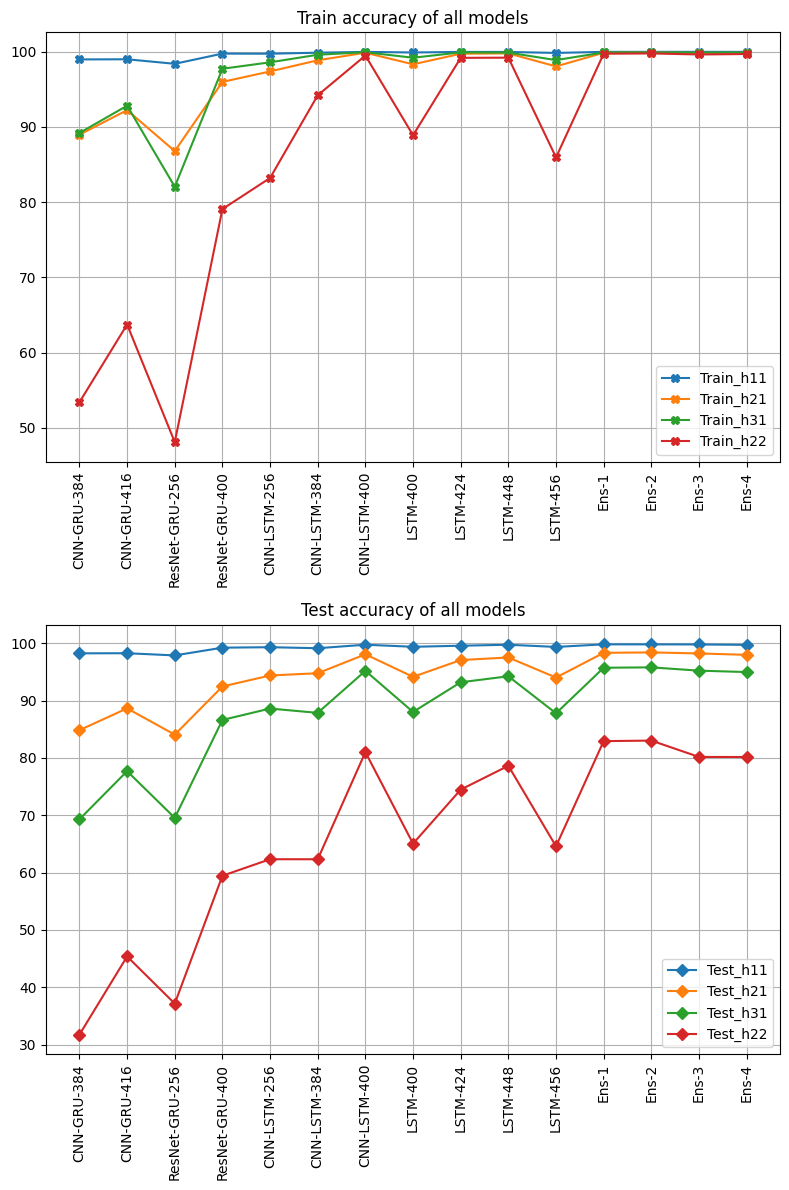

In [59]:
fig, ax = plt.subplots(2,1, figsize = (8,12), tight_layout = True)
df_72['Train_h11'].plot(ax = ax[0], style='X-')
df_72['Train_h21'].plot(ax = ax[0],style='X-')
df_72['Train_h31'].plot(ax = ax[0],style='X-')
df_72['Train_h22'].plot(ax = ax[0],style='X-')
ax[0].grid()
ax[0].set_title('Train accuracy of all models')
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_xticks(range(len(df_72.index)))
ax[0].set_xticklabels(df_72.index)
ax[0].legend(loc = 'lower right')

df_72['Test_h11'].plot(ax = ax[1], style='D-')
df_72['Test_h21'].plot(ax = ax[1],style='D-')
df_72['Test_h31'].plot(ax = ax[1],style='D-')
df_72['Test_h22'].plot(ax = ax[1],style='D-')
ax[1].grid()
ax[1].set_title('Test accuracy of all models')
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_xticks(range(len(df_72.index)))
ax[1].set_xticklabels(df_72.index)
ax[1].legend()

plt.savefig('Train_test_4x_accuracies_all')

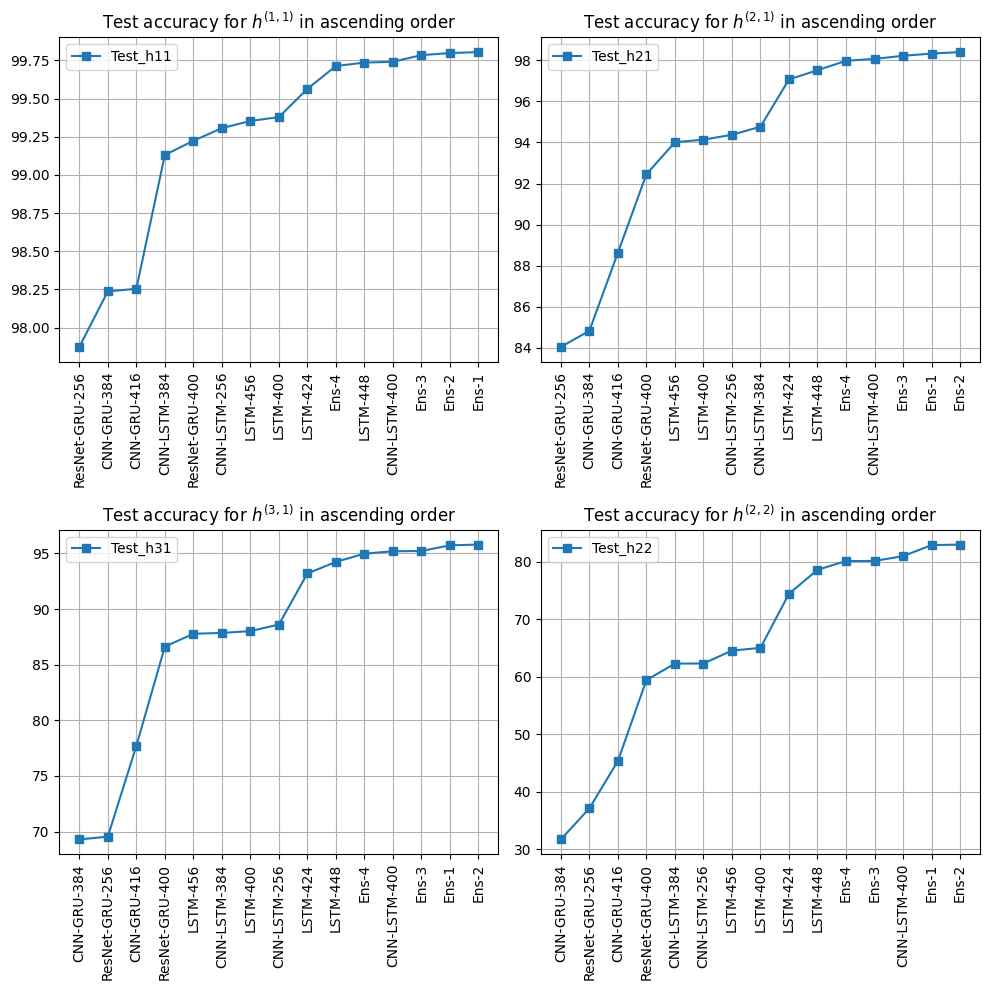

In [60]:
plot_acc_hodge(df_72, 'Train')

## MSE, MAE, R2

In [61]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2
#Perfect score values (benchmark of the target with itself)
#MSE, MAE -> 0,  R2 -> 1: perfect agreement
mse_bm = mse(y_test, y_test)
mae_bm = mae(y_test, y_test)
r2_bm = r2(y_test, y_test)
mse_bm, mae_bm, r2_bm

(0.0, 0.0, 1.0)

In [62]:
#Gather all the predictions together into an array
pred_list = np.array([yt_cnn_gru_384, yt_cnn_gru_416, yt_rsnet_gru_256, 
                      yt_rsnet_gru_400, yt_cnn_lstm_256, yt_cnn_lstm_384,
                      yt_cnn_lstm_400,  yt_lstm_400, yt_lstm_424,
                      yt_lstm_448, yt_lsm_456,
                      yts_ens_1, yts_ens_2, yts_ens_3, yts_ens_4])

scores_72= get_mse_mae_rs_scores(pred_list, y_test)
pred_dict = write_pred_list(scores_72)
df_pred = pd.DataFrame(pred_dict, index = mds)
df_pred.to_csv('pred_mse_mae_all.csv')
df_pred

,MSE_all,MSE_h11,MSE_h21,MSE_h31,MSE_h22,MAE_all,MAE_h11,MAE_h21,MAE_h31,MAE_h22,R2_all,r2_h11,r2_h21,r2_h31,r2_h22
CNN-GRU-384,3.063604,0.026345,0.288621,0.717943,11.221506,0.584066,0.020173,0.183728,0.387055,1.745309,0.976415,0.995510,0.918559,0.996170,0.995423
CNN-GRU-416,2.516005,0.022359,0.213170,0.592623,9.235866,0.446427,0.018814,0.136455,0.294771,1.335669,0.982277,0.996189,0.939849,0.996838,0.996233
ResNet-GRU-256,3.441552,0.032859,0.327509,0.815907,12.589934,0.585590,0.024578,0.199893,0.400178,1.717711,0.973124,0.994399,0.907586,0.995647,0.994864
ResNet-GRU-400,1.797119,0.016093,0.124828,0.429316,6.618239,0.291314,0.010042,0.087939,0.181614,0.885661,0.989261,0.997257,0.964777,0.997710,0.997300
CNN-LSTM-256,1.564763,0.012664,0.094177,0.371702,5.780509,0.250990,0.008590,0.065061,0.153127,0.777180,0.991732,0.997841,0.973426,0.998017,0.997642
CNN-LSTM-384,1.793952,0.012129,0.089523,0.422266,6.651888,0.263005,0.009667,0.060937,0.164395,0.817023,0.991926,0.997933,0.974739,0.997747,0.997287
CNN-LSTM-400,0.981793,0.004417,0.034841,0.225327,3.662587,0.117395,0.003081,0.023192,0.068031,0.375274,0.996680,0.999247,0.990169,0.998798,0.998506
LSTM-400,1.523907,0.012284,0.099190,0.363841,5.620315,0.255210,0.007955,0.068782,0.162137,0.781966,0.991421,0.997906,0.972011,0.998059,0.997707
LSTM-424,1.025199,0.007354,0.049256,0.245902,3.798285,0.156235,0.005234,0.034129,0.091378,0.494201,0.995497,0.998747,0.986101,0.998688,0.998451
LSTM-448,0.920742,0.004924,0.048185,0.214291,3.415570,0.137493,0.003290,0.030286,0.080768,0.435626,0.995757,0.999161,0.986404,0.998857,0.998607


# Ensembles - 5-fold-CV

In [63]:
ytsLe5, acctsLe5 = get_pred_n_acc(lstm_cv_list, device, 
                                  test_loader, num_iter = len(test_loader))
ytsL3e, acctsLe3e = get_pred_n_acc([lstm_cv_list[0],lstm_cv_list[1],lstm_cv_list[4]],
                                        device, test_loader, num_iter = len(test_loader))
ytsL2e, acctsLe2e = get_pred_n_acc([lstm_cv_list[1],lstm_cv_list[4]],
                                        device, test_loader, num_iter = len(test_loader))

ytsL3m,  acctsLe3m = get_pred_n_acc([lstm_cv_list[1],lstm_cv_list[4],cnn_lstm_400d72],
                                        device, test_loader, num_iter = len(test_loader))
ytsL4m,  acctsLe4m = get_pred_n_acc([lstm_cv_list[1],lstm_cv_list[4],
                                             cnn_lstm_400d72, lstm_448],
                                        device, test_loader, num_iter = len(test_loader))
ytsL5m,  acctsLe5m = get_pred_n_acc([lstm_cv_list[1],lstm_cv_list[4],
                                             cnn_lstm_400d72, lstm_448, lstm_424],
                                        device, test_loader, num_iter = len(test_loader))

pred_5fcve = np.array([ytsLe5, ytsL3e, ytsL2e, ytsL3m, ytsL4m, ytsL5m])
acc_5fcv = np.array([acctsLe5,acctsLe3e,acctsLe2e,
                    acctsLe3m,acctsLe4m, acctsLe5m])
acc_5fcv

array([[99.74494443, 97.74424883, 94.13924267, 76.81202626],
       [99.80180747, 98.31011886, 95.29692995, 82.43925868],
       [99.79904713, 98.46414592, 95.58234927, 83.03549247],
       [99.82609848, 98.68055671, 96.10791832, 84.66740644],
       [99.84045225, 98.70595185, 96.25918504, 85.03177153],
       [99.83769191, 98.72140976, 96.32322496, 84.83689141]])

In [67]:
mds3 = [ 'CNN-LSTM-400', 'Ens-1', 'Ens-2', 'Ens-3',
    'LSTM-448-f0','LSTM-448-f1','LSTM-448-f2',
    'LSTM-448-f3','LSTM-448-f4', 'LSTM-448-5f', 'LSTM-448-f0f1f4',
    'LSTM-448-f1f4', 'Ens-f1f4-CL400', 'Ens-0f1f4-CL400'
    ]

In [69]:
test_5facc_all = np.concatenate((np.array([acctsL400, accts_ens_1, accts_ens_2,accts_ens_3]),
                                 lstm_cv_acc,
                                 acc_5fcv[:5]), axis = 0)

acc5f_dict = {'Test_h11':test_5facc_all[:,0], 'Test_h21':test_5facc_all[:,1],
              'Test_h31':test_5facc_all[:,2],'Test_h22':test_5facc_all[:,3]}
df5f = pd.DataFrame(acc5f_dict, index = mds3)
df5f.to_csv('test5f_all.csv')
df5f

,Test_h11,Test_h21,Test_h31,Test_h22
CNN-LSTM-400,99.740528,98.068313,95.188725,81.007193
Ens-1,99.804016,98.324473,95.724231,82.925079
Ens-2,99.797391,98.398450,95.790479,83.018930
Ens-3,99.784141,98.215715,95.215224,80.169154
LSTM-448-f0,99.699675,96.783650,92.266075,75.606861
LSTM-448-f1,99.808432,98.290244,95.343856,81.983250
LSTM-448-f2,99.043818,91.424171,82.039009,58.751663
LSTM-448-f3,99.588157,95.288097,90.197475,68.582896
LSTM-448-f4,99.707956,97.545504,93.881979,78.752546
LSTM-448-5f,99.744944,97.744249,94.139243,76.812026


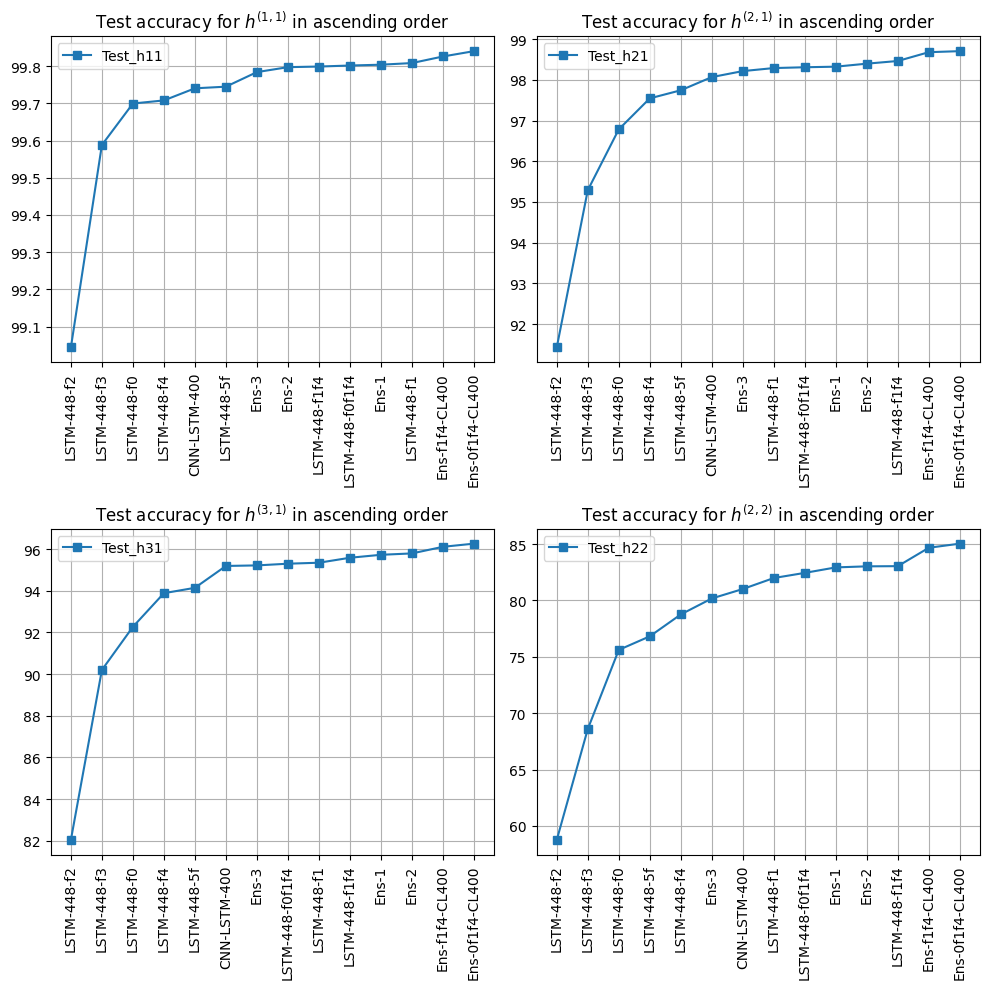

In [70]:
plot_acc_hodge(df5f, 'Test_CV')

## MSE, MAE, R2

In [75]:
pred_5fcv.shape

(10, 181137, 4)

In [78]:
pred_5fcv = np.concatenate((lstm_cv_pred, pred_5fcve[:5]), axis =0)

scores_5fcv= get_mse_mae_rs_scores(pred_5fcv, y_test)
pred_dict_cv = write_pred_list(scores_5fcv)
df_pred_cv = pd.DataFrame(pred_dict_cv, index = mds3[4:])
df_pred_cv.to_csv('pred_mse_mae_5fCV_all.csv')
df_pred_cv

,MSE_all,MSE_h11,MSE_h21,MSE_h31,MSE_h22,MAE_all,MAE_h11,MAE_h21,MAE_h31,MAE_h22,R2_all,r2_h11,r2_h21,r2_h31,r2_h22
LSTM-448-f0,1.502680,0.005846,0.067198,0.350602,5.587075,0.182685,0.003793,0.040433,0.114206,0.572307,0.993973,0.999003,0.981039,0.998130,0.997721
LSTM-448-f1,1.331656,0.003125,0.034361,0.307596,4.981544,0.118161,0.002286,0.020879,0.069213,0.380265,0.996525,0.999467,0.990304,0.998359,0.997968
LSTM-448-f2,2.272865,0.020200,0.155507,0.547906,8.367848,0.356976,0.012549,0.102817,0.244478,1.068059,0.986585,0.996557,0.956120,0.997077,0.996587
LSTM-448-f3,1.775750,0.009186,0.080817,0.420290,6.592706,0.216866,0.005510,0.055499,0.133976,0.672480,0.992675,0.998434,0.977196,0.997758,0.997311
LSTM-448-f4,1.087301,0.006928,0.043652,0.258771,4.039854,0.143518,0.004002,0.029398,0.087530,0.453143,0.995868,0.998819,0.987683,0.998619,0.998352
LSTM-448-5f,0.828281,0.003196,0.033433,0.191512,3.084980,0.137646,0.002744,0.025461,0.075832,0.446546,0.996935,0.999455,0.990566,0.998978,0.998742
LSTM-448-f0f1f4,0.797764,0.002545,0.027068,0.184888,2.976554,0.111739,0.002148,0.019604,0.064250,0.360953,0.997432,0.999566,0.992362,0.999014,0.998786
LSTM-448-f1f4,0.812173,0.002920,0.025467,0.188625,3.031678,0.107082,0.002302,0.017992,0.061550,0.346484,0.997518,0.999502,0.992814,0.998994,0.998763
Ens-f1f4-CL400,0.700576,0.002313,0.021100,0.161408,2.617483,0.093720,0.001916,0.015248,0.053015,0.304703,0.997931,0.999606,0.994046,0.999139,0.998932
Ens-0f1f4-CL400,0.622313,0.001965,0.021106,0.142544,2.323639,0.090616,0.001711,0.015055,0.050470,0.295230,0.998000,0.999665,0.994045,0.999240,0.999052


# Ensembles - 80% dataset

In [79]:
yts_ens80_1, accts_ens80_1 = get_pred_n_acc([lstm_448d, lstm_424d], 
                                            device, test_loader_80, num_iter = len(test_loader_80))

yts_ens80_2, accts_ens80_2 = get_pred_n_acc([lstm_448d,  cnn_lstm_400d72], 
                                            device, test_loader_80, num_iter = len(test_loader_80))

yts_ens80_3, accts_ens80_3 = get_pred_n_acc([lstm_448d, lstm_424d, cnn_lstm_400d72],
                                            device, test_loader_80, num_iter = len(test_loader_80))

yts_ens80_4, accts_ens80_4 = get_pred_n_acc([lstm_448d, lstm_424d,lstm_cv_list[1],
                                             cnn_lstm_400d72], device, test_loader_80, num_iter = len(test_loader_80))

yts_ens80_5, accts_ens80_5 = get_pred_n_acc([lstm_448d, lstm_424d,lstm_cv_list[1]],
                                             device, test_loader_80, num_iter = len(test_loader_80))

yts_ens80_6, accts_ens80_6 = get_pred_n_acc([lstm_448d, lstm_cv_list[1], cnn_lstm_400d72],
                                            device, test_loader_80, num_iter = len(test_loader_80))

In [80]:
accts_ens80 = np.array([accts_ens80_1, accts_ens80_2, accts_ens80_3,
                       accts_ens80_4, accts_ens80_5])
accts_ens80 

array([[99.88038498, 98.84801531, 96.85872546, 86.19090558],
       [99.85462174, 98.7707256 , 96.60293333, 85.78237427],
       [99.87946486, 98.90690271, 96.96085828, 86.78069966],
       [99.89510683, 99.02651773, 97.06483134, 87.33736957],
       [99.88682579, 98.9299056 , 96.94889678, 87.11654184]])

## Accuracies

In [81]:
mds2 = ['CNN-LSTM-400', 'LSTM-424','LSTM-448', 'LSTM-448-f1',
       'Ens-80-1', 'Ens-80-2', 'Ens-80-3','Ens-80-4']

test80_acc_all = np.concatenate((np.array([acctsL400d72, acctsl424d, acctsl448d, accts_Lf1]),
                                 accts_ens80[:4]), axis = 0)

acc80_dict = {'Test_h11':test80_acc_all[:,0], 'Test_h21':test80_acc_all[:,1],
              'Test_h31':test80_acc_all[:,2],'Test_h22':test80_acc_all[:,3]}
df80 = pd.DataFrame(acc80_dict, index = mds2)
df80.to_csv('test80_all.csv')
df80

,Test_h11,Test_h21,Test_h31,Test_h22
CNN-LSTM-400,99.734087,98.041074,95.087503,80.858836
LSTM-424,99.815977,98.191053,95.792312,81.461512
LSTM-448,99.853702,98.657551,96.260650,84.770247
LSTM-448-f1,99.801255,98.272023,95.270606,81.941812
Ens-80-1,99.880385,98.848015,96.858725,86.190906
Ens-80-2,99.854622,98.770726,96.602933,85.782374
Ens-80-3,99.879465,98.906903,96.960858,86.780700
Ens-80-4,99.895107,99.026518,97.064831,87.337370


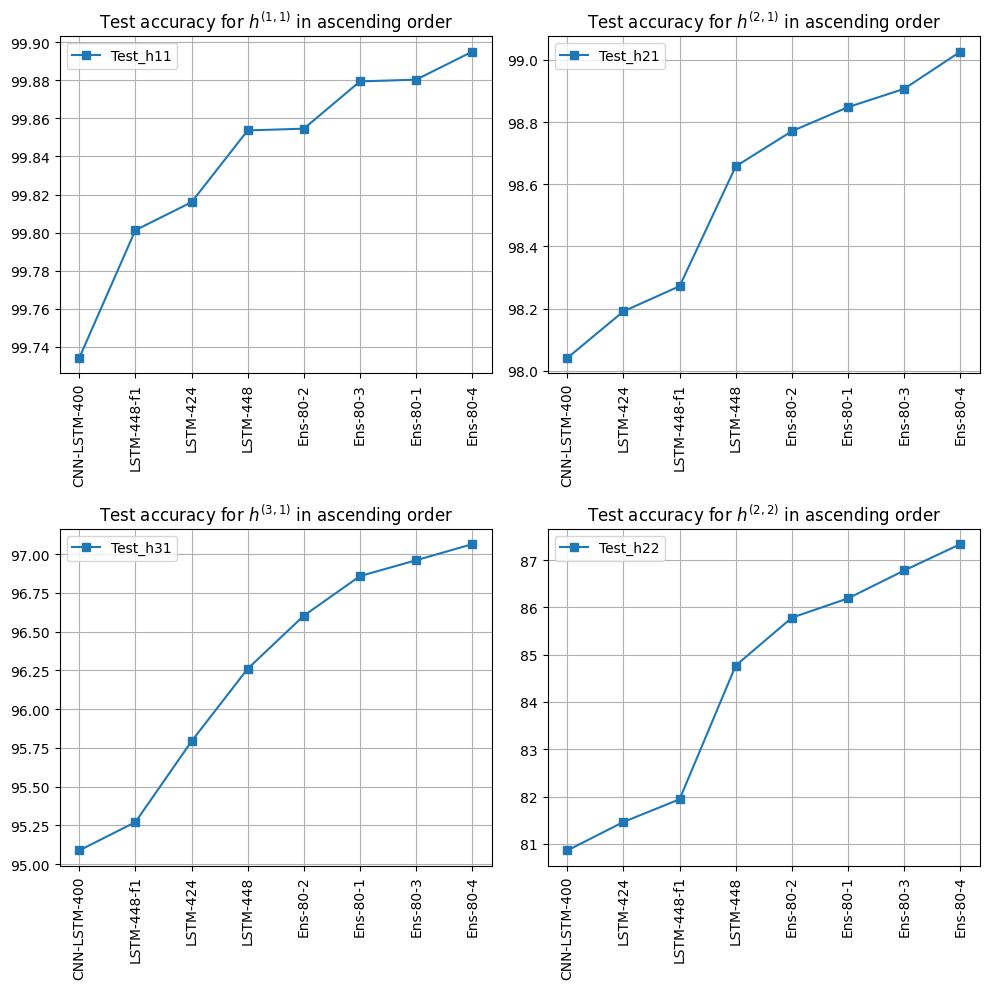

In [82]:
plot_acc_hodge(df80, 'Test80')

## MSE, MAE, R2

In [86]:
#Gather all the predictions together into an array
pred_list_80 = np.array([yt_cnn_lstm_400d72,yt_lstm_424d,
                         yt_lstm_448d, yts_Lf1,
                          yts_ens80_1, yts_ens80_2,  yts_ens80_3, 
                         yts_ens80_4])

pred_list_80.shape

(8, 108682, 4)

In [87]:
scores_80= get_mse_mae_rs_scores(pred_list_80, y_test_80)
pred_dict_80 = write_pred_list(scores_80)
df_pred_80 = pd.DataFrame(pred_dict_80, index = mds2)
df_pred_80.to_csv('pred_mse_mae_80_all.csv')
df_pred_80

,MSE_all,MSE_h11,MSE_h21,MSE_h31,MSE_h22,MAE_all,MAE_h11,MAE_h21,MAE_h31,MAE_h22,R2_all,r2_h11,r2_h21,r2_h31,r2_h22
CNN-LSTM-400,1.035332,0.004785,0.036253,0.237611,3.862682,0.120158,0.003202,0.023665,0.070205,0.383559,0.996501,0.999183,0.989677,0.998727,0.998416
LSTM-424,0.758428,0.002466,0.033851,0.177840,2.819556,0.107874,0.002043,0.021908,0.058814,0.348733,0.996958,0.999579,0.990361,0.999047,0.998844
LSTM-448,0.676418,0.002650,0.029582,0.156512,2.516930,0.093958,0.001803,0.016921,0.053477,0.303629,0.997313,0.999547,0.991577,0.999162,0.998968
LSTM-448-f1,1.588621,0.003248,0.032995,0.370162,5.948078,0.120646,0.002383,0.020813,0.071401,0.387985,0.996407,0.999445,0.990605,0.998017,0.997562
Ens-80-1,0.529085,0.001518,0.020767,0.122265,1.971789,0.080754,0.001297,0.013848,0.043540,0.264331,0.998091,0.999741,0.994087,0.999345,0.999192
Ens-80-2,0.580193,0.001951,0.022442,0.131475,2.164903,0.085290,0.001583,0.014657,0.046917,0.278004,0.997921,0.999667,0.993610,0.999296,0.999112
Ens-80-3,0.499478,0.001481,0.018458,0.113487,1.864485,0.077025,0.001279,0.012845,0.041424,0.252553,0.998280,0.999747,0.994744,0.999392,0.999236
Ens-80-4,0.573577,0.001233,0.016682,0.132543,2.143851,0.075012,0.001104,0.011455,0.040734,0.246757,0.998363,0.999789,0.995250,0.999290,0.999121
